# Test projections

In [10]:
import tifffile
from src import get_device, _PATH_DATA
from src.dataloaders import CTDataModule
import numpy as np
from tqdm import tqdm
import scipy
import torch
import matplotlib.pyplot as plt
from src.models.mlp import compute_projection_values

In [ ]:
args_dict = {
    "general": {
        "experiment_name": "test",
        "data_path":f'{_PATH_DATA}/synthetic_fibers_plenoptic/fiber_00',
        "seed":42,
        "checkpoint_path":None,
        
    },
    "training": {
        "num_epochs": 1,
        "batch_size": 10,
        "learning_rate":1e-4,
        "device":get_device().type,
        "num_workers":0,
        "num_points":256,
        "imagefit_mode":False,
        "noisy_points":True,
        "regularization_weight":1e-1,
        "noise_level":None
    },
    "model": { 
        "model_type": "mlp",
        "num_hidden_layers": 4,
        "num_hidden_features": 256,
        "num_freq_bands": 6,
        "activation_function": 'sine',
    },
}
datamodule = CTDataModule(args_dict)
datamodule.setup("test")

vol = datamodule.test_dataset.vol.numpy()

grid = (np.linspace(0, vol.shape[0]-1, vol.shape[0]),np.linspace(0, vol.shape[1]-1, vol.shape[1]),np.linspace(0, vol.shape[2]-1, vol.shape[2]))
last_idx = 0
for i in tqdm(range(16)):
    projection_shape = datamodule.test_dataset.projections.shape
    valid_indices = datamodule.test_dataset.valid_rays
    valid_indices = valid_indices.view(projection_shape)
    next_idx = torch.sum(valid_indices[i])
    points,_ = datamodule.test_dataset.sample_points(datamodule.test_dataset.start_points[last_idx:last_idx+next_idx],
                                                   datamodule.test_dataset.end_points[last_idx:last_idx+next_idx],
                                                   args_dict["training"]["num_points"])
    lengths = torch.linalg.norm((points[:,-1,:] - points[:,0,:]),dim=1)
    attenuation_values = scipy.interpolate.interpn(grid,vol,(points*(vol.shape[2]//2)+(vol.shape[2]//2-0.5)),bounds_error=False,fill_value=0)
    
    pred = compute_projection_values(points.shape[1],torch.tensor(attenuation_values),lengths)
    detector_value_hat = np.zeros((vol.shape[1],vol.shape[1]))
    detector_value_hat[valid_indices[i]] = pred.numpy()

    last_idx += next_idx
    
    fig, ax = plt.subplots(1, 3, figsize=(30, 6))
    mine = ax[0].imshow(detector_value_hat,interpolation="none")
    astra = ax[1].imshow(datamodule.test_dataset.projections[i,:,:],interpolation="none")
    difference = datamodule.test_dataset.projections[i]-detector_value_hat
    diff = ax[2].imshow(difference,interpolation="none",cmap="coolwarm")
    fig.colorbar(mine,ax=ax[0])
    fig.colorbar(astra,ax=ax[1])
    fig.colorbar(diff,ax=ax[2])
    plt.show()

# Test trained model

In [1]:
import numpy as np
import pandas as pd
import tifffile
from tqdm import tqdm
import scipy.ndimage as ndi

import torch
import torch._dynamo

from src.dataloaders import CTDataModule
from src.models.mlp import MLP
from src import get_device, _PATH_DATA, _PATH_MODELS
import matplotlib.pyplot as plt

args_dict = {
    "general": {
        "experiment_name": "test",
        "data_path":f'synthetic_fibers',
        "seed":42,
        "checkpoint_path":None,
        
    },
    "training": {
        "num_epochs": 1,
        "batch_size": 100,
        "learning_rate":1e-4,
        "device":"cuda",
        "num_workers":0,
        "num_points":256,
        "imagefit_mode":True,
        "noisy_points":False,
        "regularization_weight":1e-1,
        "noise_level":0.03
    },
    "model": { 
        "model_type": "mlp",
        "num_hidden_layers": 4,
        "num_hidden_features": 256,
        "num_freq_bands": 6,
        "encoder":"hashgrid",
        "activation_function": 'sine',
        "latent_size": 256,
        "volume_size": 300,
    },
}

/work3/s164564/envs/renner/lib/python3.10/site-packages/torch/utils/cpp_extension.py:1965: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


In [2]:
# datamodule = CTDataModule(args_dict)
# datamodule.setup()
# loader = datamodule.dataloader_for_testing()

In [2]:
# projection_shape = np.load(f"{args_dict['general']['data_path']}_projections.npy").shape
model = MLP(args_dict, 
            projection_shape=None,
            num_volumes=1000,
           ).to(args_dict['training']['device'])

checkpoint_path = f"{_PATH_MODELS}/imagefit_hashgrid_sine_latent-size-256-2024-07-29-1713/last.ckpt"
model.load_state_dict(torch.load(checkpoint_path, map_location=None)['state_dict'], strict=True)
model.eval();
model.cuda();

/tmp/ipykernel_25482/1248101701.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=None)['state_dict'], stric

In [3]:
files = pd.read_csv(f"{_PATH_DATA}/synthetic_fibers/train.csv", header=0).img_path.to_list()

In [4]:
idx = 1

In [6]:
vol = torch.tensor(tifffile.imread(f"{_PATH_DATA}/{files[idx]}"))
# vol = torch.tensor(tifffile.imread(f"{args_dict['general']['data_path']}.tif"))
vol -= vol.min()
vol = vol/vol.max()
vol = vol.permute(2,1,0)
tifffile.imwrite(f"real_vol_{idx}.tif",(vol.numpy()*255).astype("uint8"))

In [7]:
mgrid = torch.stack(torch.meshgrid(torch.linspace(-1, 1, vol.shape[0]), torch.linspace(-1, 1, vol.shape[1]), torch.linspace(-1, 1, vol.shape[2]), indexing='ij'),dim=-1)
mgrid = mgrid.view(-1,vol.shape[2],3)
outputs = torch.zeros((*mgrid.shape[:2],1))
for i in tqdm(range(mgrid.shape[1])):
    with torch.no_grad():
        vec = model.lat_vecs(torch.tensor([idx],device="cuda"))
        output = model(mgrid[:,i,:].cuda(), vec.repeat(1,mgrid.shape[0],1).view(-1,args_dict['model']['latent_size']))
    outputs[:,i,:] = output.cpu()

100%|█████████████████████████████████████████████████████████████████████████████████| 300/300 [00:06<00:00, 44.36it/s]


In [8]:
outputs = outputs.view(vol.shape)

In [9]:
print(outputs.min())
print(outputs.max())

tensor(0.0037)
tensor(0.3426)


In [10]:
outputs -= outputs.min()
outputs /= outputs.max()

In [12]:
tifffile.imwrite(f"reconstruction_mlp_{idx}.tif",(outputs.numpy()*255).astype("uint8"))

In [17]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [44]:
mask = create_circular_mask(400,400,radius=150)

In [45]:
outputs2 = outputs*mask
outputs2[:5,:,:] = 0
outputs2[-5:,:,:] = 0
outputs2 -= outputs2.min()
outputs2 /= outputs2.max()

In [46]:
tifffile.imwrite("reconstruction_mlp.tif",(outputs2.numpy()*255).astype("uint8"))

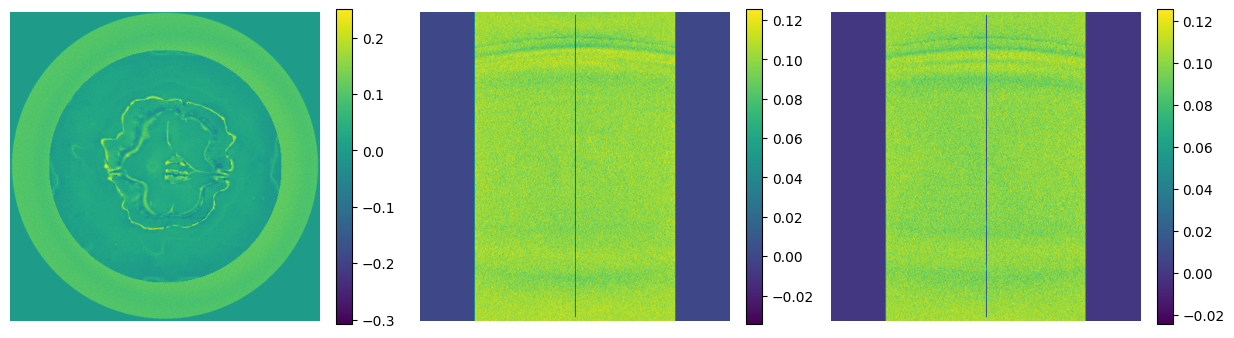

In [39]:
# residual = vol[1:] - outputs[1:]
residual = vol - outputs2
fig, ax = plt.subplots(1,3,figsize=(15,5))
slice1 = ax[0].imshow(residual[50,:,:])
plt.colorbar(slice1, ax=ax[0],fraction=0.046)
slice2 = ax[1].imshow(residual[:,50,:])
plt.colorbar(slice2, ax=ax[1],fraction=0.046)
slice3 = ax[2].imshow(residual[:,:,50])
plt.colorbar(slice3, ax=ax[2],fraction=0.046)
for i in range(3):
    ax[i].axis("off")

plt.show()

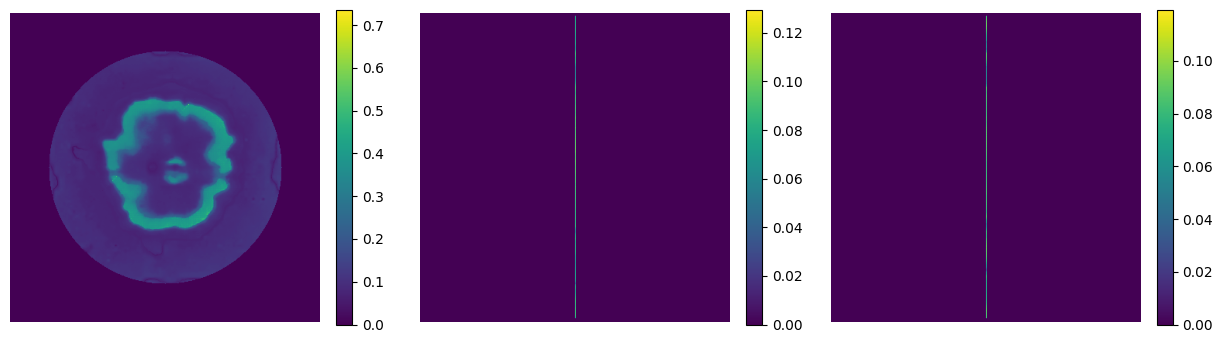

In [40]:
# residual = vol[1:] - outputs[1:]
# residual = vol - outputs
fig, ax = plt.subplots(1,3,figsize=(15,5))
slice1 = ax[0].imshow(outputs2[50,:,:])
plt.colorbar(slice1, ax=ax[0],fraction=0.046)
slice2 = ax[1].imshow(outputs2[:,50,:])
plt.colorbar(slice2, ax=ax[1],fraction=0.046)
slice3 = ax[2].imshow(outputs2[:,:,50])
plt.colorbar(slice3, ax=ax[2],fraction=0.046)
for i in range(3):
    ax[i].axis("off")

plt.show()

# Testing

In [1]:
import os
import math
import h5py
import torch
import numpy as np
import pandas as pd
import pytorch_lightning as pl

from tqdm import tqdm
from glob import glob
from tifffile import tifffile
from torch.utils.data import DataLoader

from src import _PATH_DATA

args_dict = {
    "general": {
        "experiment_name": "test",
        "data_path":f'synthetic_fibers',
        "seed":42,
        "checkpoint_path":None,
        
    },
    "training": {
        "num_epochs": 1,
        "batch_size": 100,
        "learning_rate":1e-4,
        "device":"cuda",
        "num_workers":0,
        "num_points":256,
        "imagefit_mode":True,
        "noisy_points":False,
        "regularization_weight":1e-1,
        "noise_level":0.03
    },
    "model": { 
        "model_type": "mlp",
        "num_hidden_layers": 4,
        "num_hidden_features": 256,
        "num_freq_bands": 6,
        "encoder":"hashgrid",
        "activation_function": 'sine',
        "latent_size": 256,
        "volume_sidelength": 300,
    },
}

In [2]:
class Imagefit_slice(torch.utils.data.Dataset):
    def __init__(self, args_dict,split="train"):
        
        files = pd.read_csv(f"{_PATH_DATA}/{args_dict['general']['data_path']}/{split}.csv", header=0)

        self.image_paths = files.img_path.to_list()
        self.volume_sidelength = args_dict['model']['volume_sidelength']
        
        self.mgrid = torch.stack(torch.meshgrid(
                                    torch.linspace(-1, 1, self.volume_sidelength),
                                    torch.linspace(-1, 1, self.volume_sidelength),
                                    torch.linspace(-1, 1, self.volume_sidelength),
                                    indexing='ij'),
                            dim=-1)
        self.dataset = None
    
    def __len__(self):
        return len(self.image_paths)

    def __getitems__(self,idx):
        idx = torch.tensor(idx)
        idx,_ = torch.sort(idx)
        points = self.mgrid[:,:,150].repeat(len(idx),1,1,1)
        if self.dataset is None:
            self.dataset = h5py.File(f"{_PATH_DATA}/synthetic_fibers/train_slice.hdf5", 'r')["volumes"]

        targets = torch.tensor(self.dataset[idx])

        targets = targets.to(dtype=torch.float).contiguous()
        points = points.to(dtype=torch.float).contiguous()
        return points, targets, idx

In [3]:
dataset = Imagefit_slice(args_dict)

In [4]:
def collate_fn_imagefit(batch):
    points = batch[0]
    targets = batch[1]
    img_idxs = batch[2]
    return points,targets,img_idxs
    
loader = DataLoader(dataset,
                    batch_size=10,
                    num_workers=0,
                    collate_fn=collate_fn_imagefit,
                    shuffle=True,
                   )

In [5]:
points, targets, img_idxs = next(iter(loader))

In [6]:
points.shape

torch.Size([10, 300, 300, 3])

In [72]:
lat_vecs = torch.nn.Embedding(1000,256)
torch.nn.init.normal_(lat_vecs.weight.data,
                      0.0,
                      1 / math.sqrt(256),
                    )

tensor([[-8.1513e-02,  3.5942e-02, -7.4087e-02,  ..., -5.8487e-02,
          7.5218e-02,  9.6502e-02],
        [ 2.6651e-02,  3.2984e-02,  1.0371e-02,  ..., -1.1924e-01,
         -2.3904e-03, -1.0751e-02],
        [ 1.4271e-02, -3.8402e-02,  1.2014e-02,  ..., -8.0197e-02,
          7.9578e-02,  1.3264e-03],
        ...,
        [ 2.8327e-02, -5.9160e-02,  5.7609e-02,  ..., -8.7583e-02,
          1.0874e-02,  1.2381e-01],
        [-1.4669e-02, -1.2595e-01, -4.4640e-05,  ..., -8.9788e-02,
         -1.0636e-03, -9.8611e-02],
        [-4.7055e-02,  5.6272e-02, -3.3266e-02,  ..., -1.4541e-01,
         -5.6495e-02, -1.1271e-01]])

In [1]:
from src import _PATH_DATA
import numpy as np
import pandas as pd
from tifffile import tifffile
import h5py

In [2]:
files = pd.read_csv(f"{_PATH_DATA}/synthetic_fibers/train.csv", header=0).img_path.to_list()

In [3]:
def create_hdf5_dataset(files, hdf5_path):
    # Open the first image to get the shape
    img_shape = tifffile.imread(f"{_PATH_DATA}/{files[0]}").shape
    
    # Create HDF5 file
    with h5py.File(hdf5_path, 'w') as hdf5_file:
        # Create a dataset in the file
        dataset = hdf5_file.create_dataset('volumes', (len(files), 300,300), dtype='uint8')
        
        # Loop through all images and save them to the dataset
        for i, file in enumerate(files):
            vol = tifffile.imread(f"{_PATH_DATA}/{file}")
            vol -= vol.min()
            vol = vol/vol.max()
            vol = vol.transpose(2,1,0)
            dataset[i] = vol[:,:,150]
# Usage
create_hdf5_dataset(files, f"{_PATH_DATA}/synthetic_fibers/train_slice.hdf5")


In [4]:
with h5py.File(f"{_PATH_DATA}/synthetic_fibers/train_slice.hdf5", 'r') as f:
    dataset = f["volumes"]
    print(dataset.shape)

(1000, 300, 300)


In [2]:
1000*300/10

30000.0

# Test pretrained model

In [1]:
import numpy as np
import pandas as pd
import tifffile
from tqdm.notebook import tqdm
import scipy.ndimage as ndi
import h5py

import torch
import torch._dynamo

from src.dataloaders import CTDataModule
from src.models.mlp import MLP, compute_projection_values
from src import get_device, _PATH_DATA, _PATH_MODELS
import matplotlib.pyplot as plt

args_dict = {
    "general": {
        "experiment_name": "test",
        "data_path":f'synthetic_fibers/test/000/fiber_00097',
        "seed":42,
        "checkpoint_path":"finetune_single_volume_None_sine_regularization-weight-0.1_noise-level-None_latent-size-256-2024-08-09-0913/MLP-epoch=140.ckpt",
        
    },
    "training": {
        "num_epochs": 1,
        "batch_size": 100,
        "learning_rate":1e-4,
        "device":"cuda",
        "num_workers":0,
        "num_points":512,
        "imagefit_mode":True,
        "noisy_points":False,
        "regularization_weight":1e-1,
        "noise_level":0.03
    },
    "model": { 
        "model_type": "mlp",
        "num_hidden_layers": 6,
        "num_hidden_features": 512,
        "num_freq_bands": 6,
        "encoder":None,
        "activation_function": 'sine',
        "latent_size": 256,
        "volume_size": 300,
    },
}

/work3/s164564/envs/renner/lib/python3.10/site-packages/torch/utils/cpp_extension.py:1965: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


In [2]:
# projection_shape = np.load(f"{args_dict['general']['data_path']}_projections.npy").shape
model = MLP(args_dict, 
            projection_shape=(300,300),
            num_volumes=1000,
           ).to(args_dict['training']['device'])

checkpoint_path = f"{_PATH_MODELS}/{args_dict['general']['checkpoint_path']}"
model.load_state_dict(torch.load(checkpoint_path, map_location=None)['state_dict'], strict=True)
model.eval();
model.cuda();

/tmp/ipykernel_26328/3568883711.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=None)['state_dict'], stric

In [3]:
idx = 0
with h5py.File(f"{_PATH_DATA}/synthetic_fibers/train.hdf5", 'r') as f:
    dataset = f["volumes"]
    img = dataset[idx]
    img = img.transpose(2,0,1)

mgrid = torch.stack(torch.meshgrid(torch.linspace(-1, 1, img.shape[0]), torch.linspace(-1, 1, img.shape[1]), torch.linspace(-1, 1, img.shape[1]), indexing='ij'),dim=-1)
outputs = torch.zeros_like(torch.tensor(img),dtype=torch.float)
for i in tqdm(range(mgrid.shape[0])):
    with torch.no_grad():
        vec = model.lat_vecs(torch.tensor([idx],device="cuda")).repeat(mgrid[i].shape[0],mgrid[i].shape[1],1,1).permute(2,0,1,3).contiguous().view(-1,args_dict['model']['latent_size'])
        outputs[i] = model(mgrid[i].view(-1,3).cuda(), vec).view(outputs[i].shape)


print(outputs.min())
print(outputs.max())

outputs -= outputs.min()
outputs /= outputs.max()
tifffile.imwrite(f"reconstruction_mlp_{idx}.tif",(outputs.numpy()*255).astype("uint8"))
tifffile.imwrite(f"real_vol_{idx}.tif",(img*255).astype("uint8"))

100%|███████████████████| 300/300 [00:12<00:00, 24.92it/s]


tensor(2.9766e-23)
tensor(1.)


In [7]:
vectors = model.lat_vecs(torch.arange(1000,device="cuda")).detach().cpu()

In [14]:
pdist = torch.nn.PairwiseDistance(p=2)

In [20]:
smallest_dist = 999999
smallest_idx = 0
for i in range(1,1000):
    dist = pdist(vectors[0],vectors[i])
    if dist < smallest_dist:
        smallest_dist = dist
        smallest_idx = i

In [23]:
idx = smallest_idx
with h5py.File(f"{_PATH_DATA}/synthetic_fibers/train.hdf5", 'r') as f:
    dataset = f["volumes"]
    img = dataset[idx]
    img = img.transpose(2,0,1)

mgrid = torch.stack(torch.meshgrid(torch.linspace(-1, 1, img.shape[0]), torch.linspace(-1, 1, img.shape[1]), torch.linspace(-1, 1, img.shape[1]), indexing='ij'),dim=-1)
outputs = torch.zeros_like(torch.tensor(img),dtype=torch.float)
for i in tqdm(range(mgrid.shape[0])):
    with torch.no_grad():
        vec = model.lat_vecs(torch.tensor([idx],device="cuda")).repeat(mgrid[i].shape[0],mgrid[i].shape[1],1,1).permute(2,0,1,3).contiguous().view(-1,args_dict['model']['latent_size'])
        outputs[i] = model(mgrid[i].view(-1,3).cuda(), vec).view(outputs[i].shape)


print(outputs.min())
print(outputs.max())

outputs -= outputs.min()
outputs /= outputs.max()
tifffile.imwrite(f"reconstruction_mlp_{idx}.tif",(outputs.numpy()*255).astype("uint8"))
tifffile.imwrite(f"real_vol_{idx}.tif",(img*255).astype("uint8"))

100%|███████████████████| 300/300 [00:06<00:00, 44.53it/s]


tensor(7.3635e-23)
tensor(1.)


In [ ]:
for j in tqdm(range(1,100)):
    start = model.lat_vecs(torch.tensor([0],device="cuda")).detach()
    end = model.lat_vecs(torch.tensor([smallest_idx],device="cuda")).detach()
    vec_inter = torch.lerp(start,end,j/100)
    
    idx = smallest_idx
    with h5py.File(f"{_PATH_DATA}/synthetic_fibers/train.hdf5", 'r') as f:
        dataset = f["volumes"]
        img = dataset[idx]
        img = img.transpose(2,0,1)
    
    mgrid = torch.stack(torch.meshgrid(torch.linspace(-1, 1, img.shape[0]), torch.linspace(-1, 1, img.shape[1]), torch.linspace(-1, 1, img.shape[1]), indexing='ij'),dim=-1)
    outputs = torch.zeros_like(torch.tensor(img),dtype=torch.float)
    for i in range(mgrid.shape[0]):
        with torch.no_grad():
            vec = vec_inter.repeat(mgrid[i].shape[0],mgrid[i].shape[1],1,1).permute(2,0,1,3).contiguous().view(-1,args_dict['model']['latent_size'])
            outputs[i] = model(mgrid[i].view(-1,3).cuda(), vec).view(outputs[i].shape)
    
    outputs -= outputs.min()
    outputs /= outputs.max()
    tifffile.imwrite(f"interpolations/reconstruction_mlp_{0}-{smallest_idx}_{j}-percent.tif",(outputs.numpy()*255).astype("uint8"))

In [51]:
frames = []
start = tifffile.imread("reconstruction_mlp_0.tif")[150,:,:]
end = tifffile.imread(f"reconstruction_mlp_{smallest_idx}.tif")[150,:,:]
for _ in range(10):
    frames.append(start)
for i in range(1,100):
    frames.append(tifffile.imread(f"interpolations/reconstruction_mlp_0-853_{i}-percent.tif")[150,:,:])
for _ in range(10):
    frames.append(end)
frames = np.array(frames)

In [52]:
from IPython.display import HTML
from base64 import b64encode
import matplotlib.animation as animation
from pylab import *

def ani_frame(frames,name="video"):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    im = ax.imshow(frames[0],cmap='gray',interpolation="none")
    im.set_clim([0,1])
    fig.set_size_inches([5,5])


    tight_layout()


    def update_img(n):
        tmp = frames[n]
        im.set_data(tmp)
        return im

    #legend(loc=0)
    ani = animation.FuncAnimation(fig,update_img,frames.shape[0],interval=300)
    writer = animation.writers['ffmpeg'](fps=10)

    ani.save(f'{name}.mp4',writer=writer,dpi=100)
    return ani

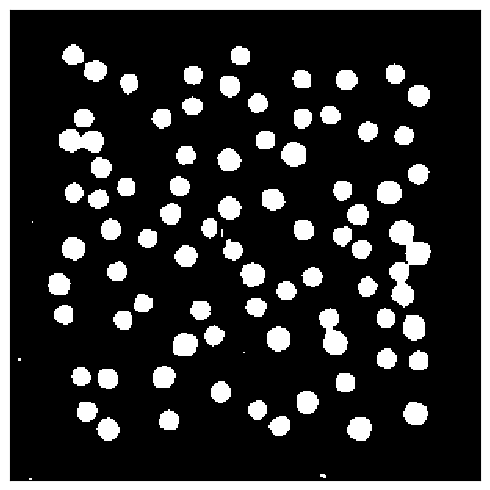

In [53]:
ani = ani_frame(frames,name="interpolation")
mp4 = open('interpolation.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [13]:
import os
import numpy as np
import pandas as pd
import tifffile
from tqdm.notebook import tqdm
import scipy.ndimage as ndi
import h5py

import torch
import torch._dynamo

from src.dataloaders import CTDataModule
from src.models.mlp import MLP, compute_projection_values
from src import get_device, _PATH_DATA, _PATH_MODELS
import matplotlib.pyplot as plt

args_dict = {
    "general": {
        "experiment_name": "test",
        "data_path":f'synthetic_fibers/test/000/fiber_00097',
        "seed":42,
        "checkpoint_path":"finetune_single_volume_None_sine_regularization-weight-0.1_noise-level-None_latent-size-256-2024-08-09-0913/MLP-epoch=140.ckpt",
        
    },
    "training": {
        "num_epochs": 1,
        "batch_size": 100,
        "model_lr":1e-4,
        "latent_lr":1e-4,
        "device":"cuda",
        "num_workers":0,
        "num_points":512,
        "imagefit_mode":True,
        "noisy_points":False,
        "regularization_weight":1e-1,
        "noise_level":0.03,
        "full_mode":False,
    },
    "model": { 
        "model_type": "mlp",
        "num_hidden_layers": 6,
        "num_hidden_features": 512,
        "num_freq_bands": 6,
        "encoder":None,
        "activation_function": 'sine',
        "latent_size": 256,
        "volume_size": 300,
    },
}

In [14]:
# datamodule = CTDataModule(args_dict)
# datamodule.setup("fit")
# train_dataloader = datamodule.train_dataloader(notebook=True)

In [15]:
# projection_shape = np.load(f"{args_dict['general']['data_path']}_projections.npy").shape
if os.path.exists(f"{_PATH_DATA}/{args_dict['general']['data_path']}_latent_vector-{args_dict['model']['latent_size']}.pt"):
    latent_vector = torch.load(f"{_PATH_DATA}/{args_dict['general']['data_path']}_latent_vector-{args_dict['model']['latent_size']}.pt").cuda()
model = MLP(args_dict, 
            projection_shape=(300,300),
            num_volumes=1000,
            latent=latent_vector,
           ).to(args_dict['training']['device'])

checkpoint_path = f"{_PATH_MODELS}/{args_dict['general']['checkpoint_path']}"
model.load_state_dict(torch.load(checkpoint_path, map_location=None)['state_dict'], strict=True)
model.eval();
model.cuda();

/tmp/ipykernel_20518/4195317335.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  latent_vector = torch.load(f"{_PATH_DATA}/{args_dict['general']['data_path']}_latent_vect

In [19]:
idx=97
data_path = f"{_PATH_DATA}/{args_dict['general']['data_path']}"
img = torch.tensor(tifffile.imread(f"{data_path}.tif"))
img -= img.min()
img = img/img.max()

mgrid = torch.stack(torch.meshgrid(torch.linspace(-1, 1, img.shape[0]), torch.linspace(-1, 1, img.shape[1]), torch.linspace(-1, 1, img.shape[1]), indexing='ij'),dim=-1)
# mgrid = mgrid.view(-1,3)
outputs = torch.zeros_like(torch.tensor(img),dtype=torch.float)
for i in tqdm(range(mgrid.shape[0])):
    with torch.no_grad():
        vec = latent_vector.repeat(mgrid[i].shape[0],mgrid[i].shape[1],1,1).permute(2,0,1,3).contiguous().view(-1,args_dict['model']['latent_size'])
        outputs[i] = model(mgrid[i].view(-1,3).cuda(), vec).view(outputs[i].shape)


print(outputs.min())
print(outputs.max())

outputs -= outputs.min()
outputs /= outputs.max()

tifffile.imwrite(f"reconstruction_mlp_{idx}.tif",(outputs.numpy()*255).astype("uint8"))
tifffile.imwrite(f"real_vol_{idx}.tif",(img.numpy()*255).astype("uint8"))

/tmp/ipykernel_20518/1373155357.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.zeros_like(torch.tensor(img),dtype=torch.float)


  0%|          | 0/300 [00:00<?, ?it/s]

tensor(1.0061e-24)
tensor(1.)


In [30]:
residual = (img-outputs)
comparison = torch.zeros_like(residual)
        
comparison[residual == -1] = 2 # Finds correctly labelled pixels
comparison[residual == 1] = 1 # Finds wrongly labelled pixels
comparison[residual == 0] = 0    # Removes background pixels


rgba_img = torch.zeros(300,300,300,4)

rgba_img[:,:,:,2][comparison[0] == 2] = 128 # Set colour of correctly labelled pixels to green
rgba_img[:,:,:,3][comparison[0] == 2] = 128 # Set transparency of correctly labelled pixels
rgba_img[:,:,:,0][comparison[0] == 1] = 128 # Set colour of wrongly labelled pixels to red
rgba_img[:,:,:,3][comparison[0] == 1] = 128 # Set transparency of wrongly labelled pixels
rgba_img[:,:,:,3][comparison[0] == 0] = 255 # Set transparency of background (fully transparent)
tifffile.imwrite(f"color_97.tif",rgba_img.to(torch.uint8).numpy())